# Zomato cleaning

On this notebook, I am cleaning the 1000 api queries from zomato_1 notebook in order to get a well organized list of restaurants in London

In [93]:
import requests
import json
from bs4 import BeautifulSoup
import urllib2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast
from sqlalchemy import create_engine

In [243]:
# read the csv containing results of the 990 queries
df_bazard=pd.read_csv("bazard_2.csv")
del df_bazard["Unnamed: 0"]

In [244]:
# retrieve restaurant information of each query.
index_erro_2=[]
df_bazard["query_result"]="" # Creation of the column where we will write the clean json result
for i in range(len(df_bazard)):
    try:
        a=ast.literal_eval(df_bazard.loc[i,"0"])[-3] #first part of the dictionary
        b=ast.literal_eval(df_bazard.loc[i,"0"])[-1] #second part of the dictionary
        a=a[a.find("{"):]
        c=ast.literal_eval(a+b) #all dictionary
        df_bazard.loc[i,"query_result"]=c["restaurants"]
    except Exception:
        index_erro_2.append(i)
        

In [245]:
#veryfying if all rows contain a json result
print "There are %d rows missing"%len(index_erro_2)

There are 16 rows missing


In [246]:
df_bazard.head()

,0,query_result
0,[' % Total % Received % Xferd Average Spe...,"[{u'restaurant': {u'cuisines': u'Drinks Only',..."
1,[' % Total % Received % Xferd Average Spe...,"[{u'restaurant': {u'cuisines': u'Mexican', u'e..."
2,[' % Total % Received % Xferd Average Spe...,"[{u'restaurant': {u'cuisines': u'Fast Food', u..."
3,[' % Total % Received % Xferd Average Spe...,[{u'restaurant': {u'cuisines': u'Healthy Food'...
4,[' % Total % Received % Xferd Average Spe...,"[{u'restaurant': {u'cuisines': u'British, Fast..."


Each row contains information about 20 restaurants.
I am now going to create a PostgreSql table that will contains information about all restaurant

In [247]:
#connecting to the data base

engine=create_engine('postgresql://localhost:5432/capstone')
conn=engine.connect()

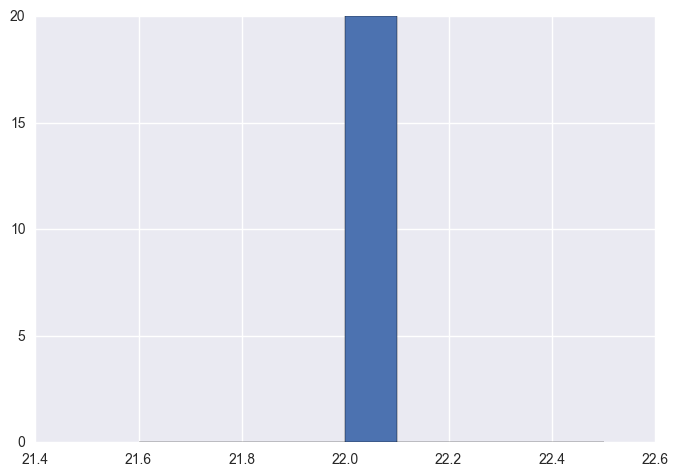

In [248]:
# let's check how many columns we will need to add in our table
query1=df_bazard.loc[0,"query_result"]
num_of_columns=[]
for i in query1:
    numcol=len(query1[1]["restaurant"].keys())
    num_of_columns.append(numcol)

plt.hist(num_of_columns)
plt.show()

Each restaurant of the first query contains 22 different kind of information. We will assume this is the case for each query

In [249]:
#But let's keep columns that are interesting to us.
query1[1]["restaurant"].keys()

['cuisines',
 'establishment_types',
 'currency',
 'featured_image',
 'average_cost_for_two',
 'deeplink',
 'id',
 'thumb',
 'is_delivering_now',
 'menu_url',
 'photos_url',
 'user_rating',
 'offers',
 'location',
 'has_table_booking',
 'events_url',
 'R',
 'price_range',
 'apikey',
 'name',
 'has_online_delivery',
 'url']

In [281]:
information_to_keep=['id','name','cuisines','establishment_types','price_range','average_cost_for_two','user_rating',\
                     'location']

#creating first column of the dataframe
df_restaurant=pd.DataFrame(columns=[information_to_keep[0]])
df_restaurant.set_value(0,information_to_keep[0],query1[1]["restaurant"][information_to_keep[0]])
#creating all column of the dataframe
for col in information_to_keep:
    if type(query1[1]["restaurant"][col]) in [dict,list]:
        df_restaurant[col]=str(query1[0]["restaurant"][col])
    else:
        df_restaurant[col]=query1[0]["restaurant"][col]
# inserting restaurant information from the first query
for i in range(1,len(query1)):
    for col in information_to_keep:
        if type(query1[i]["restaurant"][col]) in [dict,list]:
            df_restaurant.loc[i,col]=str(query1[i]["restaurant"][col])
        else:
            df_restaurant.loc[i,col]=query1[i]["restaurant"][col]
df_restaurant.head()

,id,name,cuisines,establishment_types,price_range,average_cost_for_two,user_rating,location
0,6111707,Barracuda,Drinks Only,[],2.0,25.0,"{'votes': '7', 'aggregate_rating': '2.6', 'rat...","{'city': 'London', 'locality': 'Ealing', 'city..."
1,6102909,Starbucks,Cafe,[],1.0,15.0,"{'votes': '4', 'aggregate_rating': '3.1', 'rat...","{'city': 'London', 'locality': 'Ealing', 'city..."
2,6124523,The Ashbourne,"British, Pizza",[],3.0,40.0,"{'votes': '0', 'aggregate_rating': '0', 'ratin...","{'city': 'London', 'locality': 'Ealing', 'city..."
3,6125893,Ristorante Belvedere,Italian,[],3.0,50.0,"{'votes': '1', 'aggregate_rating': '0', 'ratin...","{'city': 'London', 'locality': 'Ealing', 'city..."
4,6125648,Royal Nawaab,"Indian, Curry",[],3.0,50.0,"{'votes': '19', 'aggregate_rating': '3.5', 'ra...","{'city': 'London', 'locality': 'Greenford', 'c..."


In [282]:
#before applying the the same methods for all queries, let's try to already clean some columns
print "All values for establishment_type from the first query:",df_restaurant.establishment_types.unique()
print "----------------"
print "Structure for rating columns \n",ast.literal_eval(df_restaurant.loc[0,"user_rating"])
print "----------------"
print "Structure for location columns",ast.literal_eval(df_restaurant.loc[0,"location"])

All values for establishment_type from the first query: ['[]']
----------------
Structure for rating columns 
{'votes': '7', 'aggregate_rating': '2.6', 'rating_text': 'Average', 'rating_color': 'FFBA00'}
----------------
Structure for location columns {'city': 'London', 'locality': 'Ealing', 'city_id': 61, 'country_id': 215, 'zipcode': 'W5 2PJ', 'longitude': '-0.3003380000', 'address': '8 The Mall, Ealing, London W5 2PJ', 'latitude': '51.5141760000'}


In [283]:
#As it seems there are no information for column  , I am deleting it.
# from the rating column, I am keeping the aggregate rating values along with number of votes
# from the location columns, I am keeping the city,locality, zipcode, latitude,longitude.

rating=["aggregate_rating","votes"]
location=["city","locality", "zipcode", "latitude","longitude"]

del df_restaurant["establishment_types"]

def dictionary_value(row,name):
    dictionary=ast.literal_eval(row)
    value=dictionary[name]
    return value

In [284]:
for name in rating:
    df_restaurant[name]=df_restaurant["user_rating"].apply(lambda x: dictionary_value(x,name))
for name in location:
    df_restaurant[name]=df_restaurant["location"].apply(lambda x:dictionary_value(x,name))
    
df_restaurant.head()

,id,name,cuisines,price_range,average_cost_for_two,user_rating,location,aggregate_rating,votes,city,locality,zipcode,latitude,longitude
0,6111707,Barracuda,Drinks Only,2.0,25.0,"{'votes': '7', 'aggregate_rating': '2.6', 'rat...","{'city': 'London', 'locality': 'Ealing', 'city...",2.6,7,London,Ealing,W5 2PJ,51.5141760000,-0.3003380000
1,6102909,Starbucks,Cafe,1.0,15.0,"{'votes': '4', 'aggregate_rating': '3.1', 'rat...","{'city': 'London', 'locality': 'Ealing', 'city...",3.1,4,London,Ealing,W5 5DA,51.5110310000,-0.3051820000
2,6124523,The Ashbourne,"British, Pizza",3.0,40.0,"{'votes': '0', 'aggregate_rating': '0', 'ratin...","{'city': 'London', 'locality': 'Ealing', 'city...",0,0,London,Ealing,W5 3QU,51.5292580000,-0.2916370000
3,6125893,Ristorante Belvedere,Italian,3.0,50.0,"{'votes': '1', 'aggregate_rating': '0', 'ratin...","{'city': 'London', 'locality': 'Ealing', 'city...",0,1,London,Ealing,W5 1EE,51.5301820000,-0.2926770000
4,6125648,Royal Nawaab,"Indian, Curry",3.0,50.0,"{'votes': '19', 'aggregate_rating': '3.5', 'ra...","{'city': 'London', 'locality': 'Greenford', 'c...",3.5,19,London,Greenford,UB6 8DW,51.5336160000,-0.3187410000


In [285]:
#Now let's apply what we performed before to the missing 969 queries
information_to_keep=['id','name','cuisines','price_range','average_cost_for_two','user_rating',\
                     'location']

position=len(df_restaurant)-1
for j in range(1,len(df_bazard)):
    query=df_bazard.loc[j,"query_result"]
    for i in range(1,len(query)):
        position=position+1
        for col in information_to_keep:
            if type(query[i]["restaurant"][col]) in [dict,list]:
                df_restaurant.loc[position,col]=str(query[i]["restaurant"][col])
            else:
                df_restaurant.loc[position,col]=query[i]["restaurant"][col]

                
# taking the relevant information from the dictionary column:

for name in rating:
    df_restaurant[name]=df_restaurant["user_rating"].apply(lambda x: dictionary_value(x,name))
for name in location:
    df_restaurant[name]=df_restaurant["location"].apply(lambda x:dictionary_value(x,name))
    
df_restaurant.tail()



,id,name,cuisines,price_range,average_cost_for_two,user_rating,location,aggregate_rating,votes,city,locality,zipcode,latitude,longitude
18077,6113366,Olympia Fish & Chips Kebab,"Fast Food, Fish and Chips",1.0,15.0,"{'votes': '2', 'aggregate_rating': '0', 'ratin...","{'city': 'London', 'locality': 'Stratford', 'c...",0,2,London,Stratford,E15 4EH,51.5433690000,0.0113450000
18078,6113471,The Central,Finger Food,2.0,30.0,"{'votes': '12', 'aggregate_rating': '2.8', 'ra...","{'city': 'London', 'locality': 'Upton Park', '...",2.8,12,London,Upton Park,E6 3BD,51.5313750000,0.0453640000
18079,6115407,Cakes & Bakes,"Bakery, Desserts",1.0,15.0,"{'votes': '3', 'aggregate_rating': '0', 'ratin...","{'city': 'London', 'locality': 'East Ham', 'ci...",0,3,London,East Ham,E6 2JX,51.5335930000,0.0583860000
18080,6115309,Perfect Chicken & Grill,"Fast Food, Grill",1.0,15.0,"{'votes': '0', 'aggregate_rating': '0', 'ratin...","{'city': 'London', 'locality': 'East Ham', 'ci...",0,0,London,East Ham,E12 6PG,51.5453140000,0.0492890000
18081,6115441,Kebana Kebabish,"Fast Food, Turkish",1.0,10.0,"{'votes': '0', 'aggregate_rating': '0', 'ratin...","{'city': 'London', 'locality': 'East Ham', 'ci...",0,0,London,East Ham,E12 6PG,51.5451620000,0.0493760000


In [286]:
#deleting columns location and user_rating columns
#removing duplicate

del df_restaurant["user_rating"]
del df_restaurant["location"]

df_restaurant=df_restaurant.drop_duplicates()
df_restaurant.reset_index(drop=True,inplace=True)

total number of restaurant I registered: 3417


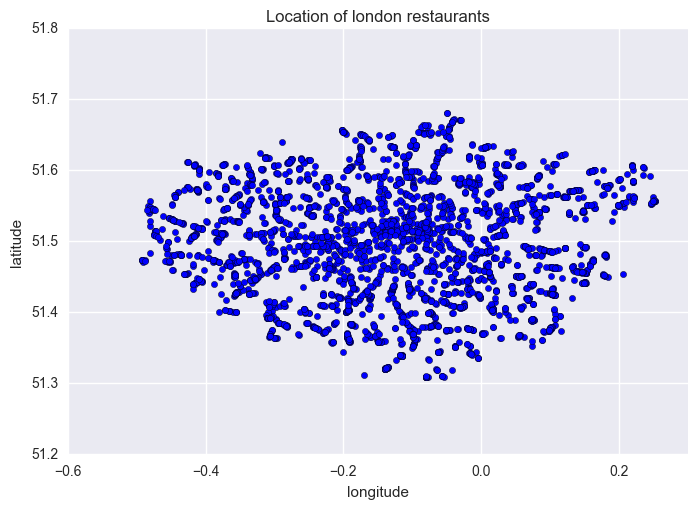

In [287]:
print "total number of restaurant I registered:", len(df_restaurant)

df_restaurant["longitude"]=df_restaurant["longitude"].astype("float")
df_restaurant["latitude"]=df_restaurant["latitude"].astype("float")

plt.scatter(df_restaurant.loc[df_restaurant["latitude"]!=0,"longitude"],df_restaurant.loc[df_restaurant["latitude"]!=0,"latitude"])
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Location of london restaurants")
plt.show()

The 3417 restaurants seem to cover all London

In [288]:
df_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3417 entries, 0 to 3416
Data columns (total 12 columns):
id                      3417 non-null object
name                    3417 non-null object
cuisines                3417 non-null object
price_range             3417 non-null float64
average_cost_for_two    3417 non-null float64
aggregate_rating        3417 non-null object
votes                   3417 non-null object
city                    3417 non-null object
locality                3417 non-null object
zipcode                 3417 non-null object
latitude                3417 non-null float64
longitude               3417 non-null float64
dtypes: float64(4), object(8)
memory usage: 320.4+ KB


In [289]:
# preparing data to be upload into the database
df_restaurant["aggregate_rating"]=df_restaurant["aggregate_rating"].astype(float)
df_restaurant["votes"]=df_restaurant["votes"].astype(int)
#removing the restaurant with 0 latitute and longitude. It must be restaurants which does not exist anymore.
df_restaurant=df_restaurant.loc[df_restaurant["latitude"]!=0,:]
df_restaurant.reset_index(drop=True,inplace=True)

In [290]:
df_restaurant.to_sql("zoomato_1",con=conn)